#  <center>基于Transformer实现英语-->西班牙语的翻译任务</center>


* 作者信息:
    * Github：[2017040264](https://github.com/2017040264)
    * AiStudio：[月光下的独孤亮](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/689988)
* 更新日期：2022.10.31





# 1.项目背景
在本项目中，我们将构建一个Sequence-to-sequence的 Transformer 模型，并在英语到西班牙语的机器翻译任务中对其进行训练。
* Sequence-to-sequence:
机器翻译是序列转换模型的一个核心问题，其输入和输出都是长度可变的序列。为了处理这种类型的输入和输出，研究人员设计出一个包含两个主要组件的架构：
    * 第一个组件是一个编码器（encoder）：它接受一个长度可变的序列作为输入，并将其转换为具有固定形状的编码状态。
    * 第二个组件是解码器（decoder）：它将固定形状的编码状态映射到长度可变的序列。

这种架构被称为编码器-解码器（encoder-decoder）架构，如下图所示：

![](https://ai-studio-static-online.cdn.bcebos.com/a7cadcd296924fec8f50146faa7d0c1db5c39f0712474be6a3dfe1b44d3270c9)

* Transformer:
Transformer是Sequence-to-sequence架构的一种实例，其诞生于2017年的《Attention is all you need》,诞生之处该模型就展示出了强大的魅力，刷新了NLP领域的大部分SOTA。现如今在Transformer在CV领域应用也得到了十分广泛的应用。Transformer的框架图如下：

![](https://ai-studio-static-online.cdn.bcebos.com/ca0931928b4a41af97a318f66957767c9ffda9b248634f4182cfda80e6a3923a)



* 机器翻译：
机器翻译（machine translation）指的是将序列从一种语言自动翻译成另一种语言。事实上，这个研究领域可以追溯到数字计算机发明后不久的20世纪40年代， 特别是在第二次世界大战中使用计算机破解语言编码。几十年来，在使用神经网络进行端到端学习的兴起之前，统计学方法在这一领域一直占据主导地位。因为统计机器翻译（statisticalmachine translation）涉及了翻译模型和语言模型等组成部分的统计分析，因此基于神经网络的方法通常被称为 `神经机器翻译（neuralmachine translation）`，用于将两种翻译模型区分开来。




# 2.环境设置

我们需要的依赖主要有：
* paddle系列：组装数据集、搭建模型框架
* padldenlp系列：数据处理
* numpy:  NumPy (Numerical Python) 是 Python 语言的一个扩展程序库，支持大量的维度数组与矩阵运算，此外也针对数组运算提供大量的数学函数库
* collections: 主要使用Counter，快速构建语料库字典
* string: 字符串库，我们要使用标点符号集合
* functools：主要使用partial，用于数据集的构建工作
* random: 随机函数库
* matplotlib.pyplot：画图使用

In [1]:
import paddle
import paddlenlp
from paddle.io import Dataset
from paddlenlp.data import Vocab

import numpy as np
import string
import random
import matplotlib.pyplot as plt
from functools import partial
from collections import Counter

# 3.数据集
使用Anki提供的`English-to-Spanish`翻译数据集,下载地址为：[English-to-Spanish数据集](http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip)。该数据集总共包含118964条（English,Spanish）语句对。示例如下：


| English | Spanish | 
| -------- | -------- |
| Go on home.    |Vete a casa.  | 
| I can jump.   |Puedo saltar.|




## 3.1 加载数据集
数据集的加载有两种方式：

1. 通过链接下载，该方法可能存在下载速度慢等不便利的情况，不推荐。

2. 我们已经下载好并上传至AiStudio平台，使用方便，强烈推荐。我们的数据集地址：[【NLP】English-Spanish](https://aistudio.baidu.com/aistudio/datasetdetail/173968/0)

In [2]:
# 下载数据集

# from paddle.utils.download import get_path_from_url
# URL = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
# get_path_from_url(URL, "./data")
# text_file='data/spa-eng/spa.txt' # 数据集路径

In [3]:
# 使用我们提供的数据集

text_file='data/data173968/spa.txt' # 数据集路径

## 3.2 添加[start] token与 [end] token
为目标语言：西班牙语，添加[start] token与 [end] token

In [4]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [5]:
for _ in range(5):
    print(random.choice(text_pairs))

('Are you seriously thinking about getting a divorce?', '[start] ¿Estás pensando seriamente en divorciarte? [end]')
('I bought it.', '[start] Lo he comprado. [end]')
('He was my student. Now he teaches my children.', '[start] Era alumno mío, ahora enseña a mis hijos. [end]')
('It seems Tom knows Mary.', '[start] Parece que Tom conoce a Mary. [end]')
('Tom has done a magnificent job.', '[start] Tom ha hecho un excelente trabajo. [end]')


## 3.3划分数据集

In [6]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [7]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]

val_eng_texts = [pair[0] for pair in val_pairs]
val_spa_texts = [pair[1] for pair in val_pairs]

test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]

## 3.4 数据集预处理
* save_punctuation=True:  保留标点符号，在标点之前（之后）加空格；
* save_punctuation=False: 删除所有的标点

In [8]:
def pre_process(datas,save_punctuation=False):
    dataset=[]
    # 定义标点符号集合
    
    strip_chars = string.punctuation + "¿¡" 
    strip_chars = strip_chars.replace("[", "")
    strip_chars = strip_chars.replace("]", "")

    for i in range(len(datas)):
        lowercase=datas[i].lower() # 全部转为小写

        out=""
        if save_punctuation:
            # 在标点符号之前加空格，需注意有特殊情况
            for low in lowercase:
                if low in strip_chars:
                    if low=="¿"or low=="¡": # 西班牙语的【反问号、反叹号】...百度一下，你就知道
                        out+=low+" "
                    else:
                        out+=" "+low
                else:
                    out+=low
        else:
            # 也可以选择删除除所有的标点
            for low in lowercase:
                if low not in strip_chars:
                    out+=low
                    
        dataset.append(out)
    return dataset

In [9]:
train_eng_texts_pre=pre_process(train_eng_texts)
train_spa_texts_pre=pre_process(train_spa_texts)

val_eng_texts_pre=pre_process(val_eng_texts)
val_spa_texts_pre=pre_process(val_spa_texts)

test_eng_texts_pre=pre_process(test_eng_texts)
test_spa_texts_pre=pre_process(test_spa_texts)

In [10]:
print("预处理结果展示：")
print("英语：标准化处理之前：",train_eng_texts[0])
print("英语：标准化处理之后：",train_eng_texts_pre[0])

print("西班牙语：标准化处理之前：",train_spa_texts[0])
print("西班牙语：标准化处理之后：",train_spa_texts_pre[0])

预处理结果展示：
英语：标准化处理之前： Tom wants to stay single.
英语：标准化处理之后： tom wants to stay single
西班牙语：标准化处理之前： [start] Tom quiere seguir soltero. [end]
西班牙语：标准化处理之后： [start] tom quiere seguir soltero [end]


## 3.5 统计句子长度
* 通过统计句子长度进而合理的网络的输入向量的长度
从统计信息可以看出，英语和西班牙语的句子长度大部分都在20以下

#### 3.5.1 英语句子长度

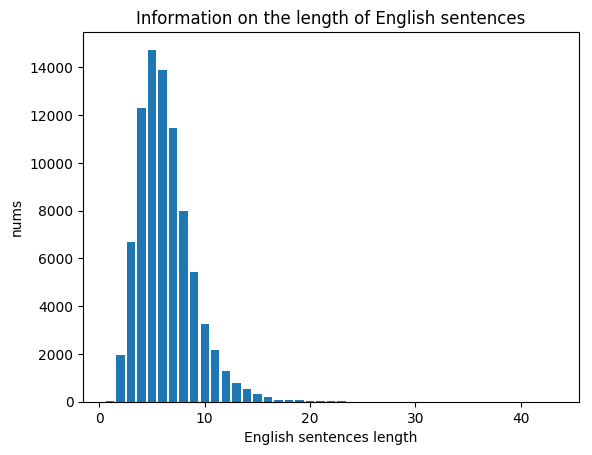

In [11]:
dicta=dict()
for text in train_eng_texts_pre:
    lent=len(text.split())
    if lent in dicta.keys():
        dicta[lent]+=1
    else:
        dicta[lent]=1
lita=sorted(dicta.items(),key=lambda x:x[0],reverse=True)

x=[l[0] for l in lita]
y=[l[1] for l in lita]
plt.bar(x, y)  
plt.xlabel('English sentences length')
plt.ylabel('nums')
plt.title('Information on the length of English sentences')
plt.show()

#### 3.5.2 西班牙语句子长度

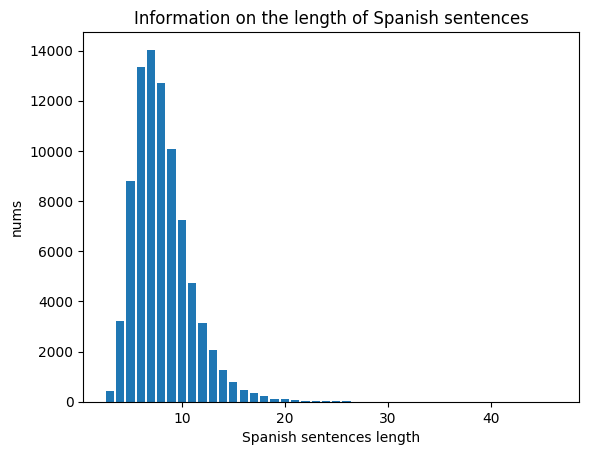

In [12]:
dicta=dict()
for text in train_spa_texts_pre:
    lent=len(text.split())
    if lent in dicta.keys():
        dicta[lent]+=1
    else:
        dicta[lent]=1
lita=sorted(dicta.items(),key=lambda x:x[0],reverse=True)

x=[l[0] for l in lita]
y=[l[1] for l in lita]
plt.bar(x, y)  
plt.xlabel('Spanish sentences length')
plt.ylabel('nums')
plt.title('Information on the length of Spanish sentences')
plt.show()

## 3.6 用训练集分别构造英语和西班牙语的语料库

In [13]:
def build_cropus(data):
    crpous=[]
    for i in range(len(data)):
        cr=data[i].strip().lower()
        cr=cr.split()
        crpous.extend(cr)
    return crpous

eng_crpous=build_cropus(train_eng_texts_pre)
spa_crpous=build_cropus(train_spa_texts_pre)

print(eng_crpous[:3])
print(spa_crpous[:3])

['tom', 'wants', 'to']
['[start]', 'tom', 'quiere']


In [14]:
# 根据给定的词汇量,按照词汇出现的频率构造词典，
def build_dict(corpus,vocab_size):
    # 首先统计每个不同词的频率（出现的次数），使用一个词典记录
    word_freq_dict = dict()
    for word in corpus:
        if word not in word_freq_dict:
            word_freq_dict[word] = 0
        word_freq_dict[word] += 1

    # 将词典中的词，按照出现次数排序，出现次数越高，排序越靠前
    word_freq_dict = sorted(word_freq_dict.items(), key = lambda x:x[1], reverse = True)


    # 构造2个不同的词典
    # 每个词到id的映射关系：word2id_dict
    # 每个id到词的映射关系：id2word_dict
    word2id_dict = {'<pad>':0,'<unk>':1}
    id2word_dict = {0:'<pad>',1:'<unk>'}

    # 按照频率，从高到低，开始遍历每个单词，并为这个单词构造一个独一无二的id
    i=2
    for word, freq in word_freq_dict:
        if i<vocab_size:
            # curr_id = len(word2id_dict)
            word2id_dict[word] = i
            id2word_dict[i] = word
            i+=1
        else: # 超过指定的词汇量，指向<unk>
            word2id_dict[word]=1
    return word2id_dict, id2word_dict

In [15]:
vocab_size = 15000 #设置词汇量，英语和西班牙语可分开设置；但为减少参数，我们在这里设置一个统一词汇量
eng2id_dict,id2eng_dict=build_dict(eng_crpous,vocab_size)
spa2id_dict,id2spa_dict=build_dict(spa_crpous,vocab_size)

print("我们设置的英语总词汇为：",vocab_size,'\t我们设置的英语总词汇为：',vocab_size)
print("总的英语词汇量为：",len(eng2id_dict),"\t\t我们实际使用的英语词汇量为",len(id2eng_dict))
print("总的西班牙语词汇量为：",len(spa2id_dict),"\t我们实际使用的西班牙语词汇量为",len(id2spa_dict))

我们设置的英语总词汇为： 15000 	我们设置的英语总词汇为： 15000
总的英语词汇量为： 12092 		我们实际使用的英语词汇量为 12092
总的西班牙语词汇量为： 22445 	我们实际使用的西班牙语词汇量为 15000


## 3.7 输入向量化


In [16]:

def build_tensor(data,dicta,maxlen):
    tensor=[]
    for i in range(len(data)):
        subtensor=[]
        lista=data[i].split()
        for j in range(len(lista)):
            index=dicta.get(lista[j])
            # 对于训练解和测试集，可能会出现未在词表中的词汇，此时index会返回None
            if index==None:
                index=1
            subtensor.append(index)
    
        if len(subtensor) < maxlen:
            subtensor+=[0]*(maxlen-len(subtensor))
        else:
            subtensor=subtensor[:maxlen]

        tensor.append(subtensor)
    return np.array(tensor)

In [17]:
sequence_length = 20 # 语句长度我们统一设置为20，可以依据3.5小结的统计信息分开设置

train_eng_tensor=build_tensor(train_eng_texts_pre,eng2id_dict,sequence_length)
val_eng_tensor=build_tensor(val_eng_texts_pre,eng2id_dict,sequence_length)
test_eng_tensor=build_tensor(test_eng_texts_pre,eng2id_dict,sequence_length)

train_spa_tensor=build_tensor(train_spa_texts_pre,spa2id_dict,sequence_length+1)
val_spa_tensor=build_tensor(val_spa_texts_pre,spa2id_dict,sequence_length+1)
test_spa_tensor=build_tensor(test_spa_texts_pre,spa2id_dict,sequence_length+1)

In [18]:
print(val_eng_texts_pre[0])
print(val_eng_tensor[0])

print(val_spa_texts_pre[0])
print(val_spa_tensor[0])

tom is an intelligent person
[   6    8   67 1244  285    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[start] tom es una persona inteligente [end]
[  2   8  12  19 243 676   3   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


## 3.8 封装数据集

In [19]:
class MyDataset(Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, eng,spa):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        self.eng = eng
        self.spa=spa

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        return self.eng[index], self.spa[index]

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return self.eng.shape[0]



In [20]:
def prepare_input(inputs,padid=0):

    src=np.array([inputsub[0] for inputsub in inputs])
    trg=np.array([inputsub[1] for inputsub in inputs])
    trg_mask =(trg[:,:-1]!=padid).astype(paddle.get_default_dtype())
    return src,trg[:,:-1],trg[:,1:,np.newaxis],trg_mask 

In [21]:
# 封装数据集

BATCH_SIZE=64 

train_dataset = MyDataset(train_eng_tensor,train_spa_tensor)
train_loader = paddle.io.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True,collate_fn=partial(prepare_input))

val_dataset=MyDataset(val_eng_tensor,val_spa_tensor)
val_loader=paddle.io.DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True,collate_fn=partial(prepare_input))

In [22]:
for i,data in enumerate(val_loader):
    for d in data:
        print(d.shape)
    break

[64, 20]
[64, 20]
[64, 20, 1]
[64, 20]


# 4.模型组网



In [23]:
# 为方便调试网络，我们提前定义一些参数
embed_dim=256 # 词嵌入embedding的维度
latent_dim=2048 # feed forward 前馈神经网络的相关参数
num_heads=8 # 多头注意力机制的‘头’数

## 4.1 Encoder
Encoder部分主要包含了多头注意力机制、层归一化层以及前馈神经网络序列。
* MultiHeadAttention ：使用`paddle.nn.MultiHeadAttention`实现多头注意力机制，需要注意其掩码attn_mask需要的shape是[batch_szie,num_heads,sequence_legth,sequence_legth]
* Feed Forward：点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。
* LayerNorm：归一化层


In [24]:
class TransformerEncoder(paddle.nn.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = paddle.nn.MultiHeadAttention(num_heads=num_heads, embed_dim=embed_dim, dropout =0.1)

        
        self.dense_proj =paddle.nn.Sequential(
            paddle.nn.Linear(embed_dim, dense_dim), 
            paddle.nn.ReLU(),
            paddle.nn.Linear(dense_dim, embed_dim) )

        self.layernorm_1 = paddle.nn.LayerNorm(embed_dim)
        self.layernorm_2 = paddle.nn.LayerNorm(embed_dim)
        self.supports_masking = True

    def forward(self, inputs, mask=None):
        padding_mask=None
        if mask is not None:
            padding_mask = paddle.cast(mask[:, np.newaxis, np.newaxis, :], dtype="int32")
        #print("inputs.shape",inputs.shape)

        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attn_mask=padding_mask)
        #print("attention_output.shape",attention_output.shape)

        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

# pencoder=TransformerEncoder(embed_dim, latent_dim, num_heads)
# print(pencoder)
# inputs=paddle.rand([64,20,256])
# print("inputs.shape:",inputs.shape)
# out=pencoder(inputs)
# print("out.shape:",out.shape)

## 4.2 位置编码
Transformer模型并不包括任何的循环或卷积网络，所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。我们用`paddle.nn.Embedding`实现位置编码，其中`num_embeddings=sequence_length`。

In [25]:
class PositionalEmbedding(paddle.nn.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super(PositionalEmbedding, self).__init__()
        self.token_embeddings = paddle.nn.Embedding(num_embeddings =vocab_size, embedding_dim =embed_dim)
        self.position_embeddings = paddle.nn.Embedding(num_embeddings =sequence_length, embedding_dim =embed_dim)

        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def forward(self, inputs):
        length = inputs.shape[-1]
        positions = paddle.arange(start=0, end=length, step=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return paddle.not_equal(inputs, 0)

# ps=PositionalEmbedding(20,15000,256)
# print(ps)
# inputs=paddle.randint(0,15000,[64,20])
# print("inputs.shape:",inputs.shape)
# out=ps(inputs)
# print("out.shape:",out.shape)

## 4.3 Decoder
编码器含有两个多头注意力组件，一个用于处理西班牙语的输入，另一个用于处理编码器的输出和前一个多头注意力机制的输出。

In [26]:
class TransformerDecoder(paddle.nn.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads):
        super(TransformerDecoder, self).__init__()
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = paddle.nn.MultiHeadAttention(num_heads=num_heads, embed_dim=embed_dim)

        self.attention_2 = paddle.nn.MultiHeadAttention(num_heads=num_heads, embed_dim=embed_dim)

        self.dense_proj = paddle.nn.Sequential(
            paddle.nn.Linear(embed_dim, latent_dim), 
            paddle.nn.ReLU(),
            paddle.nn.Linear(latent_dim, embed_dim) )

        self.layernorm_1 = paddle.nn.LayerNorm(embed_dim)
        self.layernorm_2 = paddle.nn.LayerNorm(embed_dim)
        self.layernorm_3 = paddle.nn.LayerNorm(embed_dim)
        self.supports_masking = True

    def forward(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs) #[batch_size, equence_length, sequence_length]
        padding_mask=None
        if mask is not None:
            padding_mask = paddle.cast(mask[:, np.newaxis, :], dtype="int32")
            padding_mask = paddle.minimum(padding_mask, causal_mask)

        # attn_mask: [batch_size, n_head, sequence_length, sequence_length]
        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attn_mask=causal_mask)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attn_mask=padding_mask,
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = inputs.shape
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = paddle.arange(sequence_length)[:, np.newaxis]
        j = paddle.arange(sequence_length)
        mask = paddle.cast(i >= j, dtype="int32") #[sequence_length, sequence_length]
        mask = paddle.reshape(mask, (1,1, input_shape[1], input_shape[1])) #[1, equence_length, sequence_length]
        mult = paddle.concat(
            [paddle.to_tensor(64,dtype='int32'), paddle.to_tensor([1,1, 1], dtype="int32")],
            axis=0,) #[batch_size,1,1]
        return paddle.tile(mask, mult) #[batch_size, equence_length, sequence_length]

# decoder=TransformerDecoder(embed_dim, latent_dim, num_heads)
# print(decoder)

# inputs=paddle.rand([64,20,256])
# enout=paddle.rand([64,20,256])

# out=decoder(inputs,enout)
# print("out.shape:",out.shape)

## 4.4 搭建Transformer模型

In [27]:

class Transformer(paddle.nn.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads,sequence_length, vocab_size):
        super(Transformer, self).__init__()

        self.ps1=PositionalEmbedding(sequence_length, vocab_size, embed_dim)
        self.encoder=TransformerEncoder(embed_dim, latent_dim, num_heads)

        self.ps2=PositionalEmbedding(sequence_length, vocab_size, embed_dim)
        self.decoder=TransformerDecoder(embed_dim, latent_dim, num_heads) 

        self.drop=paddle.nn.Dropout(p=0.5)

        self.lastLinear=paddle.nn.Linear(embed_dim,vocab_size)

        self.softmax=paddle.nn.Softmax()

    def forward(self,encoder_inputs,decoder_inputs):

        # 编码器
        encoder_emb=self.ps1(encoder_inputs)
        encoder_outputs=self.encoder(encoder_emb)

        # 解码器
        deocder_emb=self.ps2(decoder_inputs)
        decoder_outputs=self.decoder(deocder_emb,encoder_outputs)

        # dropout
        out=self.drop(decoder_outputs)

        #最后输出
        out=self.lastLinear(out)
        #out=self.softmax(self.lastLinear(out))

        return out

trans=Transformer(embed_dim, latent_dim, num_heads,sequence_length, vocab_size)
encoder_inputs=paddle.randint(0,15000,[64,20])
decoder_inputs=paddle.randint(0,15000,[64,20])
out=trans(encoder_inputs,decoder_inputs)
print("out.shape:",out.shape)

paddle.summary(trans,input_size=[(64,20),(64,20)],dtypes='int32')

W1031 20:31:59.264416 14770 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1031 20:31:59.268676 14770 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


out.shape: [64, 20, 15000]
-------------------------------------------------------------------------------------------
    Layer (type)               Input Shape               Output Shape         Param #    
     Embedding-1                [[64, 20]]              [64, 20, 256]        3,840,000   
     Embedding-2                  [[20]]                  [20, 256]            5,120     
PositionalEmbedding-1           [[64, 20]]              [64, 20, 256]            0       
      Linear-1               [[64, 20, 256]]            [64, 20, 256]         65,792     
      Linear-2               [[64, 20, 256]]            [64, 20, 256]         65,792     
      Linear-3               [[64, 20, 256]]            [64, 20, 256]         65,792     
      Linear-4               [[64, 20, 256]]            [64, 20, 256]         65,792     
MultiHeadAttention-1                []                  [64, 20, 256]            0       
     LayerNorm-1             [[64, 20, 256]]            [64, 20, 256]  

{'total_params': 14439064, 'trainable_params': 14439064}

# 5.模型训练与评估

## 5.1 自定义loss函数

In [28]:
class CrossEntropy(paddle.nn.Layer):
    def __init__(self):
        super(CrossEntropy,self).__init__()

    def forward(self,pre,real,trg_mask):

        # 返回的数据类型与pre一致，除了axis维度(未指定则为-1)，其他维度也与pre一致
        # logits=pre,[batch_size,sequence_len,word_size],猜测会进行argmax操作，[batch_size,sequence_len,1]
        # 默认的soft_label为False，lable=real,[bacth_size,sequence_len,1]
        cost=paddle.nn.functional.softmax_with_cross_entropy(logits=pre,label=real)
        
        # 删除axis=2 shape上为1的维度
        # 返回结果的形状应为 [batch_size,sequence_len]
        cost=paddle.squeeze(cost,axis=[2])

        # trg_mask 的形状[batch_size,suqence_len]
        # * 这个星号应该是对应位置相乘，返回结果的形状 [bathc_szie,sequence_len]
        masked_cost=cost*trg_mask

        # paddle.mean 对应轴的对应位置求平均， 在这里返回结果为 [sequence_len]
        # paddle.sum 求解方法与paddle.mean一致，最终返回的结果应为[1]
        return paddle.sum(paddle.mean(masked_cost,axis=[0]))

## 5.2 训练与验证

In [29]:
epochs = 10   
trans=Transformer(embed_dim, latent_dim, num_heads,sequence_length, vocab_size)
model=paddle.Model(trans)


model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.001,parameters=model.parameters()),
                loss=CrossEntropy(), 
                metrics=paddle.metric.Accuracy())

model.fit(train_data=train_loader, 
            epochs=epochs,
             eval_data= val_loader,
             verbose =2,
             log_freq =100,
             callbacks=[paddle.callbacks.VisualDL('./log')])

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10
step  100/1301 - loss: 40.4366 - acc: 0.3845 - 23ms/step
step  200/1301 - loss: 39.2942 - acc: 0.2620 - 23ms/step
step  300/1301 - loss: 32.5688 - acc: 0.2163 - 23ms/step
step  400/1301 - loss: 34.8820 - acc: 0.1962 - 22ms/step
step  500/1301 - loss: 34.8768 - acc: 0.1872 - 22ms/step
step  600/1301 - loss: 32.3677 - acc: 0.1819 - 22ms/step
step  700/1301 - loss: 33.2725 - acc: 0.1793 - 22ms/step
step  800/1301 - loss: 31.3508 - acc: 0.1780 - 22ms/step
step  900/1301 - loss: 27.0325 - acc: 0.1779 - 22ms/step
step 1000/1301 - loss: 27.5817 - acc: 0.1786 - 22ms/step
step 1100/1301 - loss: 25.2771 - acc: 0.1797 - 22ms/step
step 1200/1301 - loss: 27.1765 - acc: 0.1811 - 22ms/step
step 1300/1301 - loss: 23.1802 - acc: 0.1829 - 22ms/step
step 1301/1301 - loss: 25.7411 - acc: 0.1829 - 22ms/step
Eval begin...
step 100/278 - loss: 24.3538 - acc: 0.2119 - 15ms/step
step 200/278

10个epoch下验证集的loss与Accuracy曲线图：

![](https://ai-studio-static-online.cdn.bcebos.com/2d3e2fb0fb0c46c7999da12ca96af25e55d5ddad045b4f85b3419dad0774af87)

![](https://ai-studio-static-online.cdn.bcebos.com/4b9492bedc8b47a58af3474236f2c70d96e6a7e219774e53aeae719759efa559)





# 6. 结果预测

In [30]:
def evalute(eng):
    
    encoder_input=paddle.unsqueeze(eng,axis=0)
    decoded_sentence = "[start]"
        
    for i in range(sequence_length):
        decoder_input=paddle.to_tensor(build_tensor([decoded_sentence],spa2id_dict,sequence_length))
        pre=trans(encoder_input,decoder_input)
        sampled_token_index = np.argmax(pre[0, i, :])
        sampled_token = id2spa_dict.get(sampled_token_index)
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break

    return decoded_sentence

In [31]:
def translate():
    with open('result.txt','w+') as re:
        #for i in tqdm(range(len(test_eng_tensor))):
        for i in range(5):    
            result=evalute(paddle.to_tensor(test_eng_tensor[i]))
            re.write(result+'\n')
            #print(result)
translate()

In [32]:
with open('result.txt','r') as re:
    pre=re.readlines()

for i in range(5):
    print('英语: ',test_eng_texts[i])
    print('真实的西班牙语：',test_spa_texts_pre[i])
    print('预测的西班牙语：',pre[i])

英语:  It's been more than a month.
真实的西班牙语： [start] ha pasado más de un mes [end]
预测的西班牙语： [start] ha sido más de un mes [end]

英语:  My parents picked me up from school.
真实的西班牙语： [start] mis padres me recogieron de la escuela [end]
预测的西班牙语： [start] mis padres me <unk> del colegio [end]

英语:  If I don't fail, I will get my driving license before New Year.
真实的西班牙语： [start] si no suspendo conseguiré mi carné de conducir antes de año nuevo [end]
预测的西班牙语： [start] si no <unk> <unk> mi licencia de conducir hasta mi nuevo año [end]

英语:  Tom said he's Canadian.
真实的西班牙语： [start] tom dijo que es canadiense [end]
预测的西班牙语： [start] tom dijo que es canadiense [end]

英语:  They had fun with us.
真实的西班牙语： [start] ellas se entretuvieron con nosotras [end]
预测的西班牙语： [start] ellos se <unk> con nosotros [end]

